## 문제 설명
- New York 시의 부동산 선호도 예측 문제. 
- 간단한 파생변수, 통계량, 날짜변수 추가. 
- Text data를 tf-idf, count-vectorizer, SVD로 유효한 피쳐로 변환

## Data fields
- bathrooms: number of bathrooms
- bedrooms: number of bathrooms
- building_id
- created
- description
- display_address
- features: a list of features about this apartment
- latitude
- listing_id
- longitude
- manager_id
- photos: a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
- price: in USD
- street_address
- interest_level: this is the `target variable`. It has 3 categories: '`high`', '`medium`', '`low`'

# Make Quick Baseline

## 1. 데이터 가져오기
- 캐글내의 노트북을 이용할 경우 다음 경로에 train, test, submission data가 저장되어있다. 
- data 전처리에 필요한 pandas와 numpy를 가져온다. 
- train, test 데이터를 펼쳐볼 시 컬럼이 잘릴 수 있다. display option에서 보여지는 컬럼의 수를 늘려준다. 

In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/two-sigma-connect-rental-listing-inquiries/images_sample.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/Kaggle-renthop.torrent
/kaggle/input/two-sigma-connect-rental-listing-inquiries/sample_submission.csv.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip


In [27]:
pd.options.display.max_columns = 999


train = pd.read_json("/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip")
test = pd.read_json("/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip")

- train 과 test를 합치는 작업을 먼저 한다. 이는 전처리를 일괄적으로 적용하기 위해서이다. 

In [28]:
all_data = pd.concat([train, test])

## 2. categorical 변수들을 dummy로 변환
- LabelEncoder를 활용하여 `building_id`, `manager_id`, `display_address`, `street_address`를 숫자처리
- NaN의 경우 input을 list로 변환 시 똑같이 숫자처리된다.

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
C = ['building_id','manager_id','display_address','street_address']
## LE

for i in C:
    all_data[i] = le.fit_transform(list(all_data[i]))  # Nan 은 숫자처리 # list를 만나면 카테고리로 변함
    

## 3. 날짜 변수 추가
- 날짜 변수가 있는경우 pd.to_datatime과 dt로 다양한 시간 변수를 생성할 수 있다. 
- 변수중의 created로 `year`, `month`, `day`, `hour`, `weekday`, `minute`, `second`등을 추가

In [30]:
## 날짜 변수 추가

all_data['created'] = pd.to_datetime(all_data['created'])
# all_data['year'] = all_data['created'].dt.year # year는 2016으로 모두 동일
all_data['month'] = all_data['created'].dt.month
all_data['day'] = all_data['created'].dt.day
all_data['hour'] = all_data['created'].dt.hour
all_data['weekday'] = all_data['created'].dt.weekday
all_data['minute'] = all_data['created'].dt.minute
all_data['second'] = all_data['created'].dt.second

- categorical variable vs categorical variable의 경우 countplot을 통해 유효한 변수인지 확인할 수 있다. 
- 각 시간과 interst_level과의 관계를 확인할 수 있다. 

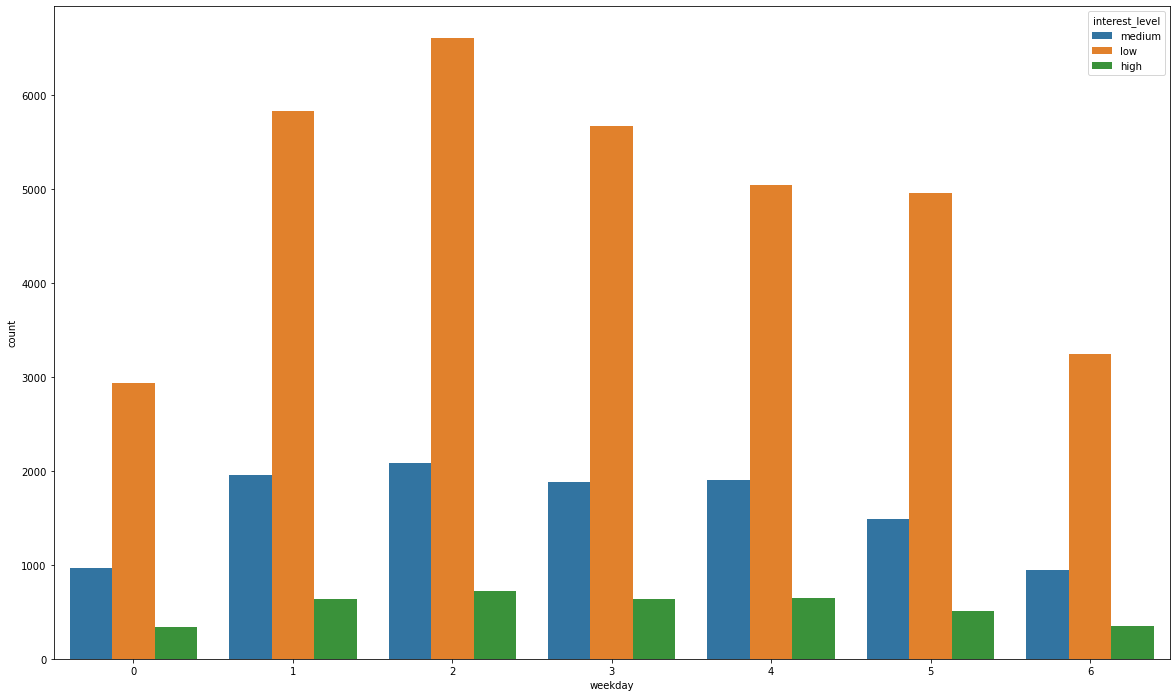

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(20,12))

sns.countplot(all_data['weekday'], hue = all_data['interest_level'])

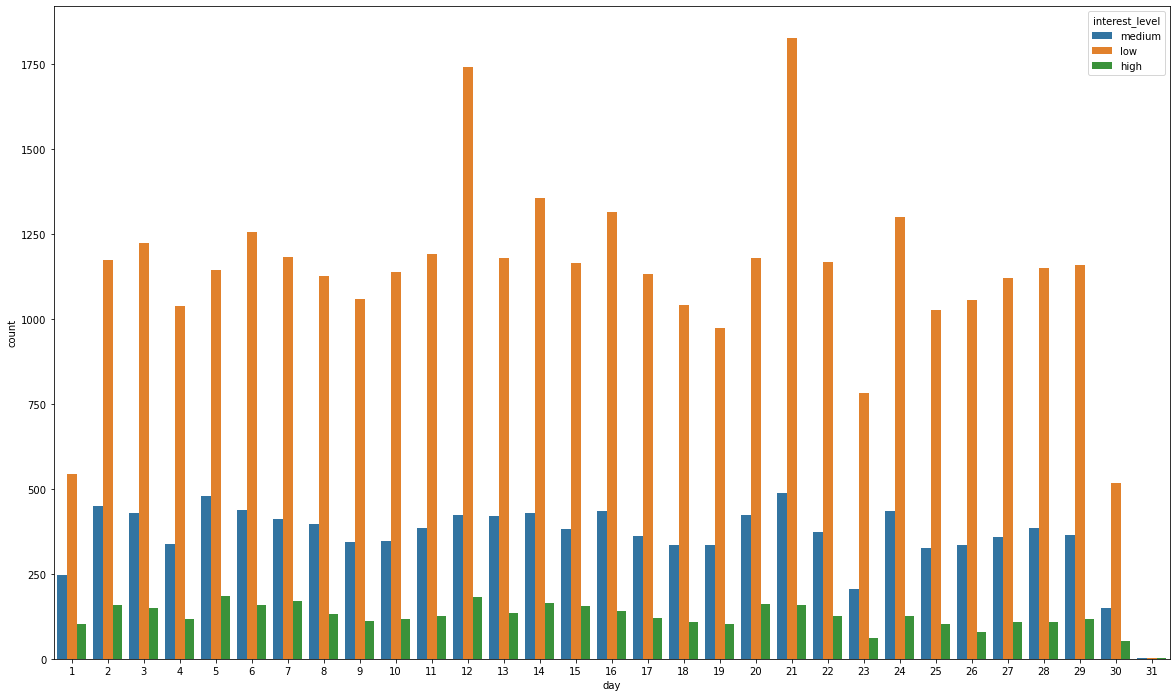

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(20,12))

sns.countplot(all_data['day'], hue = all_data['interest_level'])

## 4. 파생변수 추가 (단순 길이 추가)

- 사진의 길이 (사진이 없는 경우와 있는 경우의 차이가 큼)
- feature의 개수 (feature가 많을 수록 interest가 높아짐)
- description의 길이 (성의있는 description일수록 interest가 높아짐)

In [33]:
## 개수 변수 추가

all_data['num_photos'] = all_data['photos'].apply(len) 
all_data['num_features'] = all_data['features'].apply(len) 
all_data['num_description'] = all_data['description'].apply(lambda x: len(x.split()))

## 5. text data를 학습 가능한 수치형 데이터로 변환
- countvector와 tf-idf vector로 변환.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
cv_description = cv.fit_transform(all_data['description'])

tf = TfidfVectorizer()
tf_description = tf.fit_transform(all_data['description'])

- 10개의 vector로 축소하여 all_data에 병합.

In [35]:
## 차원축소 5만개 -> 10개
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 10)
svd_tf_description = svd.fit_transform(tf_description)
svd_cv_description = svd.fit_transform(cv_description)

all_data = pd.concat([pd.DataFrame(svd_tf_description),pd.DataFrame(svd_cv_description), all_data.reset_index(drop=True)],1) # all_data에 계속 추가

## 6. 통계량 추가
- groupby agg로 mean, count, min, max, std등 다양한 통계량을 추가

In [36]:
## 통계량 추가

manager_price = all_data.groupby('manager_id')['price'].agg(['mean', 'count', 'min', 'max', 'std']) # 통계량 추가 
display_address_price = all_data.groupby('display_address')['price'].agg(['mean', 'count', 'min', 'max', 'std']) 
street_address_price = all_data.groupby('street_address')['price'].agg(['mean','count', 'min', 'max', 'std'])  

all_data = pd.merge(all_data, manager_price, how = 'left', on = 'manager_id') 
all_data = pd.merge(all_data, display_address_price, how = 'left', on = 'display_address')
all_data = pd.merge(all_data, street_address_price, how = 'left', on = 'street_address')

# 7. train전 간단한 전처리
- all_data에서 수치형을 제외한 다른 컬럼 삭제
- 결측치 처리는 0보다는 -1이 효과가 더 높음(0이 들어있는 값과 의미가 겹칠수가 있다.)
- 다시 train data와 test data로 분리

In [72]:
# 결측치 처리
all_data2 = all_data[all_data.columns[all_data.dtypes != 'object']]
all_data2 = all_data2.drop(['created'],1)
all_data2 = all_data2.fillna(-1)

In [73]:
train2 = all_data2[:len(train)] 
test2 = all_data2.iloc[len(train):]

# 8. RF 혹은 Boosting모델을 사용
- rf, xgboost, lgbm, catboost 를 mean stack
- 일단 lgbm만 적용
- classification의 경우 metric에 따라 porbability를 제출하는게 유리한 경우가 있음

In [74]:
# from lightgbm import LGBMClassifier
# lgc = LGBMClassifier(learning_rate = 0.1)
# lgc.fit(np.array(train2), train['interest_level'])
# result = lgc.predict_proba(np.array(test2))

In [75]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier(learning_rate = 0.1)
# xgb.fit(np.array(train2), train['interest_level'])
# result = xgb.predict_proba(np.array(test2))

In [76]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(learning_rate = 0.1, verbose=20)
cbc.fit(np.array(train2), train['interest_level'])
result = cbc.predict_proba(np.array(test2))

0:	learn: 1.0269672	total: 132ms	remaining: 2m 11s
1:	learn: 0.9713792	total: 193ms	remaining: 1m 36s
2:	learn: 0.9257614	total: 253ms	remaining: 1m 24s
3:	learn: 0.8893040	total: 310ms	remaining: 1m 17s
4:	learn: 0.8608396	total: 367ms	remaining: 1m 13s
5:	learn: 0.8357953	total: 420ms	remaining: 1m 9s
6:	learn: 0.8121092	total: 481ms	remaining: 1m 8s
7:	learn: 0.7942689	total: 533ms	remaining: 1m 6s
8:	learn: 0.7767677	total: 593ms	remaining: 1m 5s
9:	learn: 0.7623215	total: 650ms	remaining: 1m 4s
10:	learn: 0.7486022	total: 712ms	remaining: 1m 3s
11:	learn: 0.7366727	total: 770ms	remaining: 1m 3s
12:	learn: 0.7264752	total: 823ms	remaining: 1m 2s
13:	learn: 0.7184694	total: 880ms	remaining: 1m 1s
14:	learn: 0.7112569	total: 941ms	remaining: 1m 1s
15:	learn: 0.7040913	total: 994ms	remaining: 1m 1s
16:	learn: 0.6971799	total: 1.05s	remaining: 1m
17:	learn: 0.6916717	total: 1.1s	remaining: 1m
18:	learn: 0.6871668	total: 1.16s	remaining: 59.8s
19:	learn: 0.6833144	total: 1.21s	remaining

163:	learn: 0.5654133	total: 9.8s	remaining: 50s
164:	learn: 0.5651475	total: 9.85s	remaining: 49.9s
165:	learn: 0.5646160	total: 9.91s	remaining: 49.8s
166:	learn: 0.5641638	total: 9.97s	remaining: 49.7s
167:	learn: 0.5637833	total: 10s	remaining: 49.6s
168:	learn: 0.5634648	total: 10.1s	remaining: 49.5s
169:	learn: 0.5629607	total: 10.1s	remaining: 49.5s
170:	learn: 0.5627014	total: 10.2s	remaining: 49.4s
171:	learn: 0.5624755	total: 10.2s	remaining: 49.3s
172:	learn: 0.5623508	total: 10.3s	remaining: 49.2s
173:	learn: 0.5620138	total: 10.4s	remaining: 49.1s
174:	learn: 0.5615969	total: 10.4s	remaining: 49.1s
175:	learn: 0.5613135	total: 10.5s	remaining: 49s
176:	learn: 0.5608960	total: 10.5s	remaining: 48.9s
177:	learn: 0.5606107	total: 10.6s	remaining: 48.9s
178:	learn: 0.5603539	total: 10.6s	remaining: 48.8s
179:	learn: 0.5599998	total: 10.7s	remaining: 48.7s
180:	learn: 0.5595114	total: 10.7s	remaining: 48.6s
181:	learn: 0.5592464	total: 10.8s	remaining: 48.5s
182:	learn: 0.55897

322:	learn: 0.5233477	total: 18.5s	remaining: 38.8s
323:	learn: 0.5231534	total: 18.6s	remaining: 38.8s
324:	learn: 0.5229144	total: 18.6s	remaining: 38.7s
325:	learn: 0.5226708	total: 18.7s	remaining: 38.7s
326:	learn: 0.5224568	total: 18.8s	remaining: 38.6s
327:	learn: 0.5223128	total: 18.8s	remaining: 38.5s
328:	learn: 0.5220917	total: 18.9s	remaining: 38.5s
329:	learn: 0.5218379	total: 18.9s	remaining: 38.4s
330:	learn: 0.5216683	total: 19s	remaining: 38.3s
331:	learn: 0.5214204	total: 19s	remaining: 38.3s
332:	learn: 0.5211863	total: 19.1s	remaining: 38.2s
333:	learn: 0.5210106	total: 19.1s	remaining: 38.2s
334:	learn: 0.5208564	total: 19.2s	remaining: 38.1s
335:	learn: 0.5207284	total: 19.2s	remaining: 38s
336:	learn: 0.5203932	total: 19.3s	remaining: 38s
337:	learn: 0.5201643	total: 19.4s	remaining: 37.9s
338:	learn: 0.5198986	total: 19.4s	remaining: 37.9s
339:	learn: 0.5197079	total: 19.5s	remaining: 37.8s
340:	learn: 0.5195170	total: 19.5s	remaining: 37.7s
341:	learn: 0.519380

484:	learn: 0.4931838	total: 27.4s	remaining: 29.1s
485:	learn: 0.4929199	total: 27.5s	remaining: 29.1s
486:	learn: 0.4927404	total: 27.6s	remaining: 29s
487:	learn: 0.4926280	total: 27.6s	remaining: 29s
488:	learn: 0.4924697	total: 27.7s	remaining: 28.9s
489:	learn: 0.4922987	total: 27.7s	remaining: 28.8s
490:	learn: 0.4921842	total: 27.8s	remaining: 28.8s
491:	learn: 0.4920036	total: 27.8s	remaining: 28.7s
492:	learn: 0.4918901	total: 27.9s	remaining: 28.7s
493:	learn: 0.4917729	total: 27.9s	remaining: 28.6s
494:	learn: 0.4916052	total: 28s	remaining: 28.5s
495:	learn: 0.4914419	total: 28s	remaining: 28.5s
496:	learn: 0.4912384	total: 28.1s	remaining: 28.4s
497:	learn: 0.4911260	total: 28.1s	remaining: 28.3s
498:	learn: 0.4910049	total: 28.2s	remaining: 28.3s
499:	learn: 0.4908036	total: 28.2s	remaining: 28.2s
500:	learn: 0.4906850	total: 28.3s	remaining: 28.2s
501:	learn: 0.4905533	total: 28.3s	remaining: 28.1s
502:	learn: 0.4903719	total: 28.4s	remaining: 28s
503:	learn: 0.4901952	

644:	learn: 0.4684389	total: 36.2s	remaining: 19.9s
645:	learn: 0.4683385	total: 36.3s	remaining: 19.9s
646:	learn: 0.4681797	total: 36.3s	remaining: 19.8s
647:	learn: 0.4680898	total: 36.4s	remaining: 19.8s
648:	learn: 0.4679500	total: 36.4s	remaining: 19.7s
649:	learn: 0.4678261	total: 36.5s	remaining: 19.7s
650:	learn: 0.4675950	total: 36.6s	remaining: 19.6s
651:	learn: 0.4674612	total: 36.6s	remaining: 19.5s
652:	learn: 0.4673618	total: 36.7s	remaining: 19.5s
653:	learn: 0.4671680	total: 36.7s	remaining: 19.4s
654:	learn: 0.4669805	total: 36.8s	remaining: 19.4s
655:	learn: 0.4668616	total: 36.8s	remaining: 19.3s
656:	learn: 0.4667436	total: 36.9s	remaining: 19.3s
657:	learn: 0.4666263	total: 36.9s	remaining: 19.2s
658:	learn: 0.4664208	total: 37s	remaining: 19.1s
659:	learn: 0.4663183	total: 37s	remaining: 19.1s
660:	learn: 0.4662257	total: 37.1s	remaining: 19s
661:	learn: 0.4660473	total: 37.1s	remaining: 19s
662:	learn: 0.4659143	total: 37.2s	remaining: 18.9s
663:	learn: 0.465812

806:	learn: 0.4467584	total: 45.3s	remaining: 10.8s
807:	learn: 0.4466046	total: 45.4s	remaining: 10.8s
808:	learn: 0.4464880	total: 45.4s	remaining: 10.7s
809:	learn: 0.4463455	total: 45.5s	remaining: 10.7s
810:	learn: 0.4462289	total: 45.5s	remaining: 10.6s
811:	learn: 0.4461604	total: 45.6s	remaining: 10.6s
812:	learn: 0.4460544	total: 45.6s	remaining: 10.5s
813:	learn: 0.4459440	total: 45.7s	remaining: 10.4s
814:	learn: 0.4457648	total: 45.7s	remaining: 10.4s
815:	learn: 0.4456728	total: 45.8s	remaining: 10.3s
816:	learn: 0.4455016	total: 45.9s	remaining: 10.3s
817:	learn: 0.4453562	total: 45.9s	remaining: 10.2s
818:	learn: 0.4452462	total: 46s	remaining: 10.2s
819:	learn: 0.4451023	total: 46s	remaining: 10.1s
820:	learn: 0.4449085	total: 46.1s	remaining: 10s
821:	learn: 0.4448000	total: 46.1s	remaining: 9.99s
822:	learn: 0.4446623	total: 46.2s	remaining: 9.94s
823:	learn: 0.4445410	total: 46.3s	remaining: 9.88s
824:	learn: 0.4444258	total: 46.3s	remaining: 9.83s
825:	learn: 0.4442

966:	learn: 0.4266675	total: 54.1s	remaining: 1.85s
967:	learn: 0.4265177	total: 54.2s	remaining: 1.79s
968:	learn: 0.4263600	total: 54.2s	remaining: 1.74s
969:	learn: 0.4262380	total: 54.3s	remaining: 1.68s
970:	learn: 0.4261366	total: 54.4s	remaining: 1.62s
971:	learn: 0.4260038	total: 54.4s	remaining: 1.57s
972:	learn: 0.4259152	total: 54.5s	remaining: 1.51s
973:	learn: 0.4257883	total: 54.5s	remaining: 1.46s
974:	learn: 0.4256468	total: 54.6s	remaining: 1.4s
975:	learn: 0.4254574	total: 54.6s	remaining: 1.34s
976:	learn: 0.4253245	total: 54.7s	remaining: 1.29s
977:	learn: 0.4251970	total: 54.7s	remaining: 1.23s
978:	learn: 0.4250602	total: 54.8s	remaining: 1.18s
979:	learn: 0.4249601	total: 54.9s	remaining: 1.12s
980:	learn: 0.4248446	total: 54.9s	remaining: 1.06s
981:	learn: 0.4247599	total: 55s	remaining: 1.01s
982:	learn: 0.4246166	total: 55s	remaining: 951ms
983:	learn: 0.4245153	total: 55.1s	remaining: 895ms
984:	learn: 0.4243626	total: 55.1s	remaining: 839ms
985:	learn: 0.424

# 9. submission파일 제출
- 대회에서 제공해주는 sub파일을 가져와서 제출용 파일로 활용
- 제출용 파일의 컬럼순서는 꼭 sub파일의 순서일 필요는 없다. 

In [79]:
sub = pd.read_csv("/kaggle/input/two-sigma-connect-rental-listing-inquiries/sample_submission.csv.zip")
sub.columns = ['listing_id', 'high', 'low', 'medium'] # 꼭 sub 순서일 필요는 없다.
sub.iloc[:,1:] = result
sub.head()

,listing_id,high,low,medium
0,7142618,0.104585,0.533640,0.361775
1,7210040,0.079495,0.791218,0.129288
2,7174566,0.003735,0.969333,0.026932
3,7191391,0.154144,0.369938,0.475918
4,7171695,0.013626,0.784977,0.201398


In [80]:
sub.to_csv('result_cbc.csv',index = 0) # baseline 코드로 public score 0.56537